# 2229022 이승연

In [ ]:
!pip install ISLP

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize,
                         poly)

import ISLP
import statsmodels.api as sm
from matplotlib.pyplot import subplots
import seaborn as sns

In [ ]:
Boston = load_data("Boston")
Boston["lstat"]

,lstat
0,4.98
1,9.14
2,4.03
3,2.94
4,5.33
...,...
501,9.67
502,9.08
503,5.64
504,6.48


# Exercise 1.1:

Do the estimatsion procedure using `torch.nn.Linear(1,1, bias=True)`. Answer the following questions.

i. Calculate $\widehat{Y}$ when `lstat`s are given by 5, 10, 15, respectively.

## 표준화

In [ ]:
X = Boston["lstat"].to_numpy()
Y = Boston["medv"].to_numpy()

# 표준화
X_standard = (X - X.mean())/X.std()
Y_standard = (Y - Y.mean())/Y.std()

### EDA

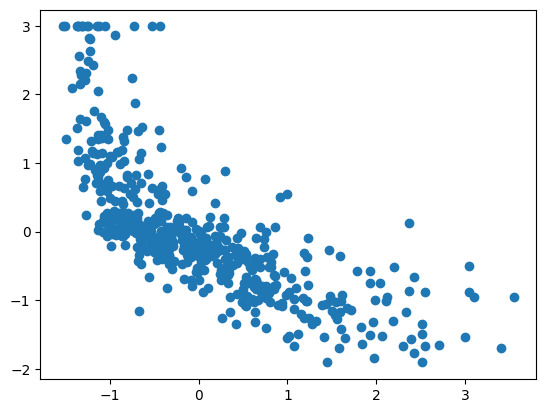

In [ ]:
plt.scatter(X_standard, Y_standard)
plt.show()

- 데이터의 분포가 직선보다는 곡선으로 보인다.

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future ve

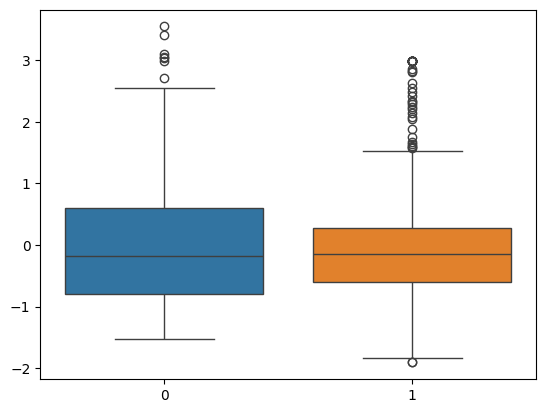

In [ ]:
sns.boxplot([X_standard, Y_standard])
plt.show()

- Y값에 이상치가 많이 존재하는 것을 알 수 있다.

### 학습

In [ ]:
# 학습에 사용할 X, Y 데이터 tensor로 변환
XX = torch.tensor(X_standard, dtype= torch.float32)
YY = torch.tensor(Y_standard, dtype= torch.float32)

# 차원 동일하게 맞추기
XX = XX.reshape(-1,1)
YY = YY.reshape(-1,1)

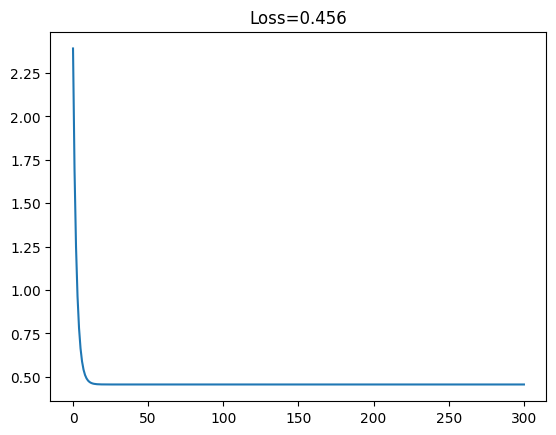

In [ ]:
# 학습
LEARN_RATE = 0.1
EPOCHS = 300
#################
forward = torch.nn.Linear(1,1,bias=True)
optimizer = torch.optim.SGD(forward.parameters(), lr=LEARN_RATE)

def loss_ft(y, yhat):
    return torch.mean((y-yhat)**2)

loss_list = []

for i in range(EPOCHS):
    Yhat = forward(XX)
    loss = loss_ft(YY, Yhat)
    loss_list.append(loss.item())

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

# 마지막 결과 저장
loss_list.append(loss.item())

plt.plot(loss_list)
plt.title(f"Loss={np.round(loss_list[-1],3)}")
plt.show()

In [ ]:
sample_lstats = torch.tensor([5,10,15], dtype=torch.float32)
sample_lstats_norm = (sample_lstats - X.mean())/X.std()

y_hat = forward(sample_lstats_norm.reshape(-1,1))
y_hat = y_hat * Y.std() + Y.mean()

print(y_hat)

tensor([[29.8036],
        [25.0533],
        [20.3031]], grad_fn=<AddBackward0>)


- 주어진 [5, 10, 15]에 대한 y_hat의 값은 [30.14, 25.17, 20.20] 이다.

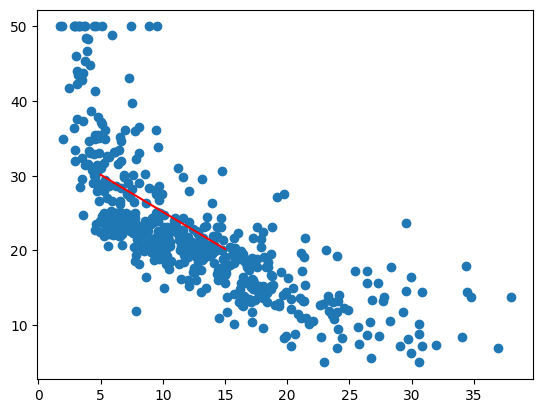

In [ ]:
plt.scatter(X,Y)
plt.plot(sample_lstats, y_hat.detach().numpy(), color='red')
plt.show()

- 그래프로 확인해보면 어느정도 잘 맞는 것을 알 수 있다.

## IQR 이상치 제거, 표준화
- 아까 데이터의 그래프를 그려보았을 때, 직선이 아니었기 때문에 이상치를 제거하고 회귀분석을 해보았다.

In [ ]:
# IQR 이상치를 제외한 인덱스를 찾는 함수
def outliers_iqr(data):
    q1, q3 = np.quantile(data, [0.25, 0.75])
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)

    return np.where((data > lower_bound) & (data < upper_bound))

In [ ]:
rid_outlier_idx_y = outliers_iqr(Boston["medv"])[0]
rid_outlier_idx_x = outliers_iqr(Boston["lstat"])[0]

rid_outlier_idx = np.intersect1d(rid_outlier_idx_x, rid_outlier_idx_y)

df = Boston.loc[rid_outlier_idx]

X = df["lstat"].to_numpy()
Y = df["medv"].to_numpy()

# 표준화
X_standard = (X - X.mean())/X.std()
Y_standard = (Y - Y.mean())/Y.std()

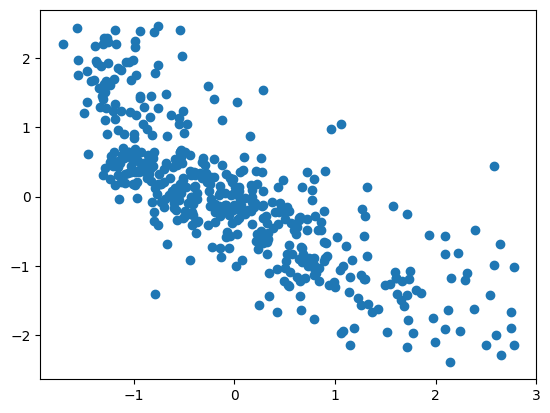

In [ ]:
plt.scatter(X_standard, Y_standard)
plt.show()

- 이상치를 제거하기 전보다 직선 모양인 것을 알 수 있다.

In [ ]:
# 학습에 사용할 X, Y 데이터 tensor로 변환
XX = torch.tensor(X_standard, dtype= torch.float32)
YY = torch.tensor(Y_standard, dtype= torch.float32)

# 차원 동일하게 맞추기
XX = XX.reshape(-1,1)
YY = YY.reshape(-1,1)

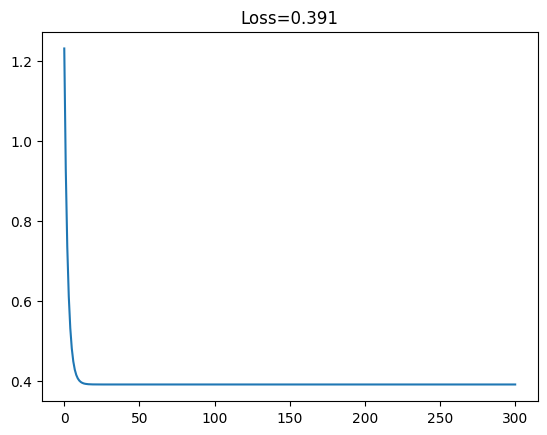

In [ ]:
# 학습
LEARN_RATE = 0.1
EPOCHS = 300
#################
forward = torch.nn.Linear(1,1,bias=True)
optimizer = torch.optim.SGD(forward.parameters(), lr=LEARN_RATE)

def loss_ft(y, yhat):
    return torch.mean((y-yhat)**2)

loss_list = []

for i in range(EPOCHS):
    Yhat = forward(XX)
    loss = loss_ft(YY, Yhat)
    loss_list.append(loss.item())

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

# 마지막 결과 저장
loss_list.append(loss.item())

plt.plot(loss_list)
plt.title(f"Loss={np.round(loss_list[-1],3)}")
plt.show()

In [ ]:
sample_lstats = torch.tensor([5,10,15], dtype=torch.float32)
sample_lstats_norm = (sample_lstats - X.mean())/X.std()

y_hat = forward(sample_lstats_norm.reshape(-1,1))
y_hat = y_hat * Y.std() + Y.mean()

print(y_hat)

tensor([[27.0022],
        [23.1338],
        [19.2653]], grad_fn=<AddBackward0>)


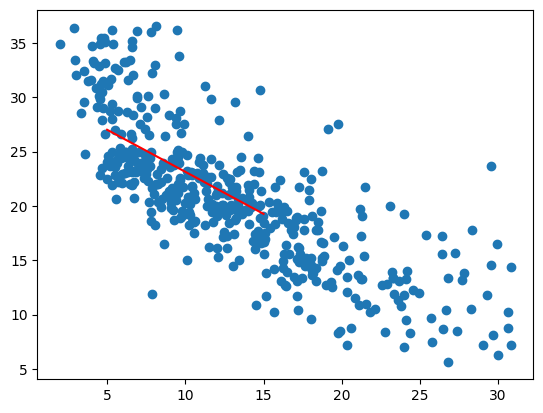

In [ ]:
plt.scatter(X,Y)
plt.plot(sample_lstats, y_hat.detach().numpy(), color='red')
plt.show()

- 예측한 값이 이상치를 제거하기 전보다 조금 더 데이터에 적합해보인다.

ii. Calculate $R^2$.

iii. Calculate AIC.

# Exercise 1.2:

Do the estimatsion procedure using `torch.nn.Linear(2,1, bias=False)`.Answer the following questions.

i. Calculate $\widehat{Y}$ when `lstat`s are given by 5, 10, 15, respectively.

In [ ]:
X = Boston["lstat"].to_numpy()
Y = Boston["medv"].to_numpy()

# 표준화
X_standard = (X - X.mean())/X.std()
Y_standard = (Y - Y.mean())/Y.std()

# bias=False로 학습하기 위해 X에 절편을 추가한다.
ones = np.ones(len(X_standard))
X_standard = np.stack([X_standard, ones], axis=1)

# 학습에 사용할 X, Y 데이터 tensor로 변환
XX = torch.tensor(X_standard, dtype= torch.float32)
YY = torch.tensor(Y_standard, dtype= torch.float32)

# 차원 동일하게 맞추기
YY = YY.reshape(-1,1)

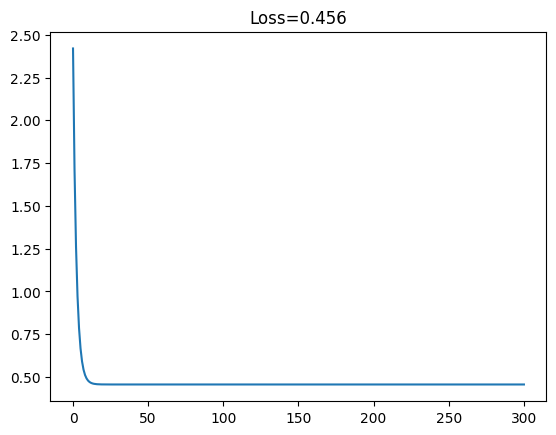

In [ ]:
# 학습
LEARN_RATE = 0.1
EPOCHS = 300
#################
forward = torch.nn.Linear(2,1,bias=False)
optimizer = torch.optim.SGD(forward.parameters(), lr=LEARN_RATE)

def loss_ft(y, yhat):
    return torch.mean((y-yhat)**2)

loss_list = []

for i in range(EPOCHS):
    Yhat = forward(XX)
    loss = loss_ft(YY, Yhat)
    loss_list.append(loss.item())

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

# 마지막 결과 저장
loss_list.append(loss.item())

plt.plot(loss_list)
plt.title(f"Loss={np.round(loss_list[-1],3)}")
plt.show()

In [ ]:
sample_lstats = torch.tensor([5,10,15], dtype=torch.float32)
sample_lstats_norm = (sample_lstats - X.mean())/X.std()

# 절편 추가
ones = torch.ones(len(sample_lstats_norm))
sample_lstats_norm = torch.stack([sample_lstats_norm, ones], axis=1)

y_hat = forward(sample_lstats_norm)
y_hat = y_hat * Y.std() + Y.mean()

print(y_hat)

tensor([[29.8036],
        [25.0533],
        [20.3031]], grad_fn=<AddBackward0>)


ii. Calculate $R^2$.

iii. Calculate AIC.

# Exercise 1.3:

Do the estimatsion procedure using `torch.nn.Linear(1,1, bias=False)` and an additional bias parameter defined by `torch.tensor`. Model itself should be the same as in Exercise 1.1 and 1.2. (Caution: However, the estimated parameter(s) should not be the exactly the same due to the randomness in the parameter initialization and batch learning.)

Answer the following questions.

i. Calculate $\widehat{Y}$ when `lstat`s are given by 5, 10, 15, respectively.

In [ ]:
X = Boston["lstat"].to_numpy()
Y = Boston["medv"].to_numpy()

# 표준화
X_standard = (X - X.mean())/X.std()
Y_standard = (Y - Y.mean())/Y.std()

# 학습에 사용할 X, Y 데이터 tensor로 변환
XX = torch.tensor(X_standard, dtype= torch.float32)
YY = torch.tensor(Y_standard, dtype= torch.float32)

# 차원 동일하게 맞추기
XX = XX.reshape(-1,1)
YY = YY.reshape(-1,1)

<ipython-input-214-737abc6e30ae>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b0 = torch.tensor(torch.randn([1]), requires_grad=True) # bias를 따로


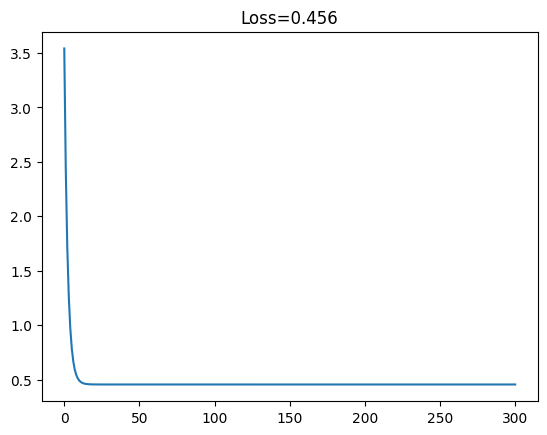

In [ ]:
# 학습
LEARN_RATE = 0.1
EPOCHS = 300
#################
b0 = torch.tensor(torch.randn([1]), requires_grad=True) # bias를 따로
forward = torch.nn.Linear(1,1,bias=False)
optimizer = torch.optim.SGD([b0, forward.weight], lr=LEARN_RATE)

def loss_ft(y, yhat):
    return torch.mean((y-yhat)**2)

loss_list = []

for i in range(EPOCHS):
    Yhat = forward(XX) + b0
    loss = loss_ft(YY, Yhat)
    loss_list.append(loss.item())

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

# 마지막 결과 저장
loss_list.append(loss.item())

plt.plot(loss_list)
plt.title(f"Loss={np.round(loss_list[-1],3)}")
plt.show()

In [ ]:
sample_lstats = torch.tensor([5,10,15], dtype=torch.float32)
sample_lstats_norm = (sample_lstats - X.mean())/X.std()
sample_lstats_norm = sample_lstats_norm.reshape(-1,1)

y_hat = forward(sample_lstats_norm) + b0
y_hat = y_hat * Y.std() + Y.mean()

print(y_hat)

tensor([[29.8036],
        [25.0533],
        [20.3031]], grad_fn=<AddBackward0>)


ii. Calculate $R^2$.

iii. Calculate AIC.

# 2.1 Exercise:

Using the standardizied `Boston` data answer the following questions.


(a) Using pytorch and customized layer, calculate the train MSE of the following model:

`medv ~ age + lstat`

(b) Using pytorch and customized layer, calculate the train MSE of the following model:

`medv ~ age + lstat + lstat**2`

(c) Using pytorch and customized layer, calculate $R^2$ of each model in (a) and (b).

(d) Repeat (a) and (b) by making use of 70% of data as train set and the remaining 30% as test set.

# 3.1 Exercise:

Using `Carseats` data answer the following questions.

(a) Using pytorch, calculate the train MSE of the following model:

`Sales ~ Advertising + ShelveLoc`

(b) Using pytorch, calculate the train MSE of the following model:

`Sales ~ Advertising`

(c) Calculate $R^2$ of each model in (a) and (b).

(d) Repeat (a) and (b) by making use of 70% of data as train set and the remaining 30% as test set.